# Implementation: K-Means (Lloyd)

[![Twitter Handle](https://img.shields.io/badge/Twitter-@gaohongnan-blue?style=social&logo=twitter)](https://twitter.com/gaohongnan)
[![LinkedIn Profile](https://img.shields.io/badge/@gaohongnan-blue?style=social&logo=linkedin)](https://linkedin.com/in/gao-hongnan)
[![GitHub Profile](https://img.shields.io/badge/GitHub-gao--hongnan-lightgrey?style=social&logo=github)](https://github.com/gao-hongnan)
![Tag](https://img.shields.io/badge/Tag-Organized_Chaos-orange)
[![Code](https://img.shields.io/badge/View-Code-blue?style=flat-square&logo=github)](https://github.com/gao-hongnan/omniverse/blob/40957563757f7dce3fb02821b42a181426857780/omnivault/machine_learning/clustering/kmeans.py)


```{contents}
```

## Imports and Dependencies

In [1]:
from __future__ import annotations

import sys
from pathlib import Path
import matplotlib.pyplot as plt


def find_root_dir(current_path: Path | None = None, marker: str = '.git') -> Path | None:
    """
    Find the root directory by searching for a directory or file that serves as a
    marker.

    Parameters
    ----------
    current_path : Path | None
        The starting path to search from. If None, the current working directory
        `Path.cwd()` is used.
    marker : str
        The name of the file or directory that signifies the root.

    Returns
    -------
    Path | None
        The path to the root directory. Returns None if the marker is not found.
    """
    if not current_path:
        current_path = Path.cwd()
    current_path = current_path.resolve()
    for parent in [current_path, *current_path.parents]:
        if (parent / marker).exists():
            return parent
    return None

root_dir = find_root_dir(marker='omnivault')

if root_dir is not None:
    sys.path.append(str(root_dir))
    from omnivault.utils.visualization.style import use_svg_display
    from omnivault.machine_learning.clustering.kmeans import KMeansLloyd, plot_kmeans, elbow_method, display_results
    from omnivault.machine_learning.metrics.pairwise.distance import manhattan_distance, euclidean_distance
    from omnivault.utils.reproducibility.seed import seed_all
else:
    raise ImportError("Root directory not found.")

import random
from functools import partial
from typing import Any, Dict, Tuple, TypeVar, Union

import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.collections import PathCollection
from rich.pretty import pprint
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits, load_iris, make_blobs
from sklearn.model_selection import train_test_split

use_svg_display()

## Implementation

We present a non-vectorized version of K-Means. I find it easier to code an
algorithm from scratch using for-loops and then vectorize it after. The code can
be found in [here](../../../omnivault/machine_learning/clustering/kmeans.py). I
include a non-runnable version here just for demonstration purposes as I already
have imported the code earlier.

````{admonition} K-Means
:class: dropdown

```python
from __future__ import annotations

from functools import partial
from typing import Any, Callable, Dict, List, Literal, Tuple

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from numpy.typing import NDArray

from omnivault.machine_learning.estimator import BaseEstimator
from omnivault.machine_learning.metrics.pairwise.distance import euclidean_distance, manhattan_distance
from omnivault.utils.reproducibility.seed import seed_all


class KMeansLloyd(BaseEstimator):
    """K-Means Lloyd's algorithm.

    Parameters
    ----------
    num_clusters : int, optional, default: 3
        The number of clusters to form as well as the number of
        centroids to generate.

    init : str, optional, default: "random"
        Method for initialization, either 'random' or 'k-means++'.

    max_iter : int, optional, default: 100
        Maximum number of iterations of the k-means algorithm for
        a single run.

    metric : str, optional, default: "euclidean"
        The distance metric used to calculate the distance between each
        sample and the centroid.

    tol : float, optional, default: 1e-8
        The tolerance with regards to the change in the within-cluster
        sum-squared-error to declare convergence.

    random_state : int, optional, default: 42
        Seed for the random number generator used during the
        initialization of the centroids.
    """

    def __init__(
        self,
        num_clusters: int = 3,
        init: Literal["random", "k-means++"] = "random",
        max_iter: int = 100,
        metric: Literal["euclidean", "manhattan"] = "euclidean",
        tol: float = 1e-8,
        random_state: int = 42,
    ) -> None:
        self._K = num_clusters  # K
        self.init = init  # random init
        self.max_iter = max_iter
        self.tol = tol

        self.metric = metric
        self.distance = self._get_distance_metric()  # get distance fn based on metric

        self.random_state = random_state
        seed_all(self.random_state, seed_torch=False, set_torch_deterministic=False)

        self._reset_clusters()  # initializes self._C = {C_1=[], C_2=[], ..., C_k=[]}

        self._C: Dict[int, List[int]]  # clusters
        self._N: int
        self._D: int
        self.t: int  # iteration counter
        self._labels: NDArray[np.floating[Any]]  # N labels np.zeros(shape=(self._N))
        self._centroids: NDArray[np.floating[Any]]  # np.zeros(shape=(self._K, self.num_features)) KxD matrix
        self._inertia: NDArray[np.floating[Any]]
        self._inertias: NDArray[np.floating[Any]]  # np.zeros(shape=(self._N)) N inertias

    @property
    def num_clusters(self) -> int:
        """Property to get the number of clusters K."""
        return self._K

    @property
    def num_features(self) -> int:
        """Property to get the number of features D."""
        return self._D

    @property
    def num_samples(self) -> int:
        """Property to get the number of samples N."""
        return self._N

    @property
    def clusters(self) -> Dict[int, List[int]]:
        """Property to get the clusters, this is our C."""
        return self._C

    @property
    def labels(self) -> NDArray[np.floating[Any]]:
        """Property to get the labels of the samples."""
        return self._labels.astype(int)

    @property
    def centroids(self) -> NDArray[np.floating[Any]]:
        """Property to get the centroids."""
        return self._centroids

    @property
    def inertia(self) -> NDArray[np.floating[Any]]:
        """Property to get the inertia."""
        return self._inertia

    def _reset_clusters(self) -> None:
        """Reset clusters."""
        self._C = {k: [] for k in range(self._K)}  # type: ignore[misc]

    def _reset_inertias(self) -> None:
        """
        Reset the inertias to zero for each sample.

        This method initializes `self._inertias`, a numpy array with
        shape (N,), to zero. It is used in the assignment step to store
        the minimum distances from each sample to its assigned centroid,
        which contributes to the cost function J, summed over all samples.
        """
        self._inertias = np.zeros(self._N)  # reset mechanism so don't accumulate

    def _reset_labels(self) -> None:
        """
        Reset the labels to zero for each sample.

        This method reinitializes `self._labels`, a numpy array with
        shape (N,), to zero, clearing previous cluster assignments.
        """
        self._labels = np.zeros(self._N)  # reset mechanism so don't accumulate

    def _init_centroids(self, X: NDArray[np.floating[Any]]) -> None:
        """
        Initialize the centroids for K-Means clustering.

        The method sets initial values for `self._centroids` based on the
        specified initialization strategy ('random' or 'k-means++').

        Parameters
        ----------
        X : NDArray[np.floating[Any]]
            A 2D array where each row is a data point.

        Raises
        ------
        ValueError
            If the `init` attribute is set to an unsupported value.
        """
        self._centroids = np.zeros(shape=(self._K, self._D))  # KxD matrix
        if self.init == "random":
            for k in range(self._K):
                self._centroids[k] = X[np.random.choice(range(self._N))]
        elif self.init == "k-means++":
            # You can implement k-means++ initialization here.
            raise NotImplementedError("k-means++ initialization is not implemented.")
        else:
            raise ValueError(f"{self.init} is not supported.")

    def _get_distance_metric(self) -> Callable[[NDArray[np.floating[Any]], NDArray[np.floating[Any]]], float]:
        """Get the distance metric based on the metric attribute.

        Returns
        -------
        Callable[[NDArray[np.floating[Any]], NDArray[np.floating[Any]]], float]
            The distance metric function.
        """
        if self.metric == "euclidean":
            return partial(euclidean_distance, squared=False)
        if self.metric == "manhattan":
            return manhattan_distance
        raise ValueError(f"{self.metric} is not supported. The metric must be 'euclidean' or 'manhattan'.")

    def _compute_argmin_assignment(
        self, x: NDArray[np.floating[Any]], centroids: NDArray[np.floating[Any]]
    ) -> Tuple[int, float]:
        """Compute the argmin assignment for a single sample x.

        In other words, for a single sample x, compute the distance between x and
        each centroid mu_1, mu_2, ..., mu_k. Then, return the index of the centroid
        that is closest to x, and the distance between x and that centroid.

        This step has O(K) complexity, where K is the number of clusters. However,
        to be more pedantic, the self.distance also has O(D) complexity,
        where D is the number of features, so it can be argued that this step has
        O(KD) complexity.

        Parameters
        ----------
        x : NDArray[np.floating[Any]]
            A single data point.
        centroids : NDArray[np.floating[Any]]
            Current centroids of the clusters.

        Returns
        -------
        Tuple[int, float]
            The index of the closest centroid and the distance to it.
        """
        min_index = -100  # some random number
        min_distance = np.inf
        for k, centroid in enumerate(centroids):
            distance = self.distance(x, centroid)
            if distance < min_distance:
                # now min_distance is the best distance between x and mu_k
                min_index = k
                min_distance = distance
        return min_index, min_distance

    def _assign_samples(self, X: NDArray[np.floating[Any]], centroids: NDArray[np.floating[Any]]) -> None:
        """Assignment step: assigns samples to clusters.

        This step has O(NK) complexity since we are looping over
        N samples, and for each sample, _compute_argmin_assignment requires
        O(K) complexity.

        Parameters
        ----------
        X : NDArray[np.floating[Any]]
            A 2D array where each row is a data point.
        centroids : NDArray[np.floating[Any]]
            Current centroids of the clusters.
        """
        self._reset_inertias()  # reset the inertias to [0, 0, ..., 0]
        self._reset_labels()  # reset the labels to [0, 0, ..., 0]
        for sample_index, x in enumerate(X):
            min_index, min_distance = self._compute_argmin_assignment(x, centroids)
            # fmt: off
            self._C[min_index].append(x) # here means append the data point x to the cluster C_k
            self._inertias[sample_index] = min_distance  # the cost of the sample x
            self._labels[sample_index] = int(min_index)  # the label of the sample x
            # fmt: on

    def _update_centroids(self, centroids: NDArray[np.floating[Any]]) -> NDArray[np.floating[Any]]:
        """Update step: update the centroid with new cluster mean.

        Parameters
        ----------
        centroids : NDArray[np.floating[Any]]
            Current centroids of the clusters.

        Returns
        -------
        NDArray[np.floating[Any]]
            Updated centroids of the clusters.
        """
        for k, cluster in self._C.items():  # for k and the corresponding cluster C_k
            mu_k = np.mean(cluster, axis=0)  # compute the mean of the cluster
            centroids[k] = mu_k  # update the centroid mu_k
        return centroids

    def _has_converged(
        self, old_centroids: NDArray[np.floating[Any]], updated_centroids: NDArray[np.floating[Any]]
    ) -> bool:
        """Checks for convergence.
        If the centroids are the same, then the algorithm has converged.
        You can also check convergence by comparing the SSE.

        Parameters
        ----------
        old_centroids : NDArray[np.floating[Any]]
            Old centroids of the clusters.
        updated_centroids : NDArray[np.floating[Any]]
            Updated centroids of the clusters.

        Returns
        -------
        bool
            True if the centroids have converged, False otherwise.
        """
        return np.allclose(updated_centroids, old_centroids, atol=self.tol)

    def fit(self, X: NDArray[np.floating[Any]]) -> KMeansLloyd:
        """
        Fit the K-Means clustering model to the data.

        This function iteratively assigns samples to clusters and updates
        centroids based on those assignments until the centroids do not
        change significantly or a maximum number of iterations is reached.

        Parameters
        ----------
        X : NDArray[np.floating[Any]]
            Data points to cluster.

        Returns
        -------
        KMeansLloyd
            The instance itself.
        """
        # fmt: off
        self._N, self._D = X.shape  # N=num_samples, D=num_features

        # step 1. Initialize self._centroids of shape KxD.
        self._init_centroids(X)

        # enter iteration of step 2-3 until convergence
        for t in range(self.max_iter):
            # copy the centroids and denote it as old_centroids
            # note that in t+1 iteration, we will update the old_centroids
            # to be the self._centroid in t iteration
            old_centroids = self._centroids.copy()

            # step 2: assignment step
            self._assign_samples(X, old_centroids)

            # step 3: update step
            # (careful of mutation without copy because I am doing centroids[k] = mu_k)
            # updated_centroids = self._update_centroids(old_centroids.copy())
            self._centroids = self._update_centroids(old_centroids.copy())

            # step 4: check convergence
            if self._has_converged(old_centroids, self._centroids):
                print(f"Converged at iteration {t}")
                self.t = t  # assign iteration index, used for logging
                break

            # do not put self._centroids here because if self._has_converged is True,
            # then this step is not updated, causing the final centroids to be the old_centroids
            # instead of the updated_centroids, especially problematic if tolerance>0
            # self._centroids = updated_centroids  # assign updated centroids to
            # self._centroids if not converged
            self._reset_clusters()  # reset the clusters if not converged

        # step 5: compute the final cost on the converged centroids
        self._inertia = np.sum(self._inertias, dtype=np.float64)
        # fmt: on
        return self

    def predict(self, X: NDArray[np.floating[Any]]) -> NDArray[np.floating[Any]]:
        """Predict cluster labels for samples in X where X can be new data or training data."""
        y_preds = np.array([self._compute_argmin_assignment(x, self._centroids)[0] for x in X])
        return y_preds


def elbow_method(X: NDArray[np.floating[Any]], min_clusters: int = 1, max_clusters: int = 10) -> None:
    """Elbow method to find the optimal number of clusters.
    The optimal number of clusters is where the elbow occurs.
    The elbow is where the SSE starts to decrease in a linear fashion."""
    inertias = []
    for k in range(min_clusters, max_clusters + 1):
        print(f"Running K-Means with {k} clusters")
        kmeans = KMeansLloyd(num_clusters=k, init="random", max_iter=500, random_state=1992)
        kmeans.fit(X)
        inertias.append(kmeans.inertia)
    plt.plot(range(min_clusters, max_clusters + 1), inertias, marker="o")
    plt.title("Elbow Method")
    plt.xlabel("Number of clusters")
    plt.ylabel("Intertia/Distortion/SSE")
    plt.tight_layout()
    plt.show()


def plot_kmeans(
    X: NDArray[np.floating[Any]], cluster_assignments: NDArray[np.floating[Any]], centroids: NDArray[np.floating[Any]]
) -> None:
    """
    Plot the K-Means clustering results using matplotlib and seaborn.

    This function visualizes the clustering output of a K-Means algorithm,
    displaying both the data points and the centroids on a scatter plot. Each
    cluster is colored differently, and centroids are marked distinctly to
    highlight their position relative to the data points.

    Parameters
    ----------
    X : NDArray[np.floating[Any]]
        A 2D array with shape (N, D) where N is the number of data points
        and D is the dimensionality of each data point. This array contains
        the coordinates of the data points.
    cluster_assignments : NDArray[np.floating[Any]]
        A 1D array with shape (N,) that contains the cluster index to which
        each data point is assigned. Each element in this array should be
        an integer representing the cluster index.
    centroids : NDArray[np.floating[Any]]
        A 2D array with shape (K, D) where K is the number of clusters and
        D is the dimensionality of the centroids. This array contains the
        coordinates of the centroids.
    """
    # Ensure that seaborn is set to its default theme.
    sns.set_theme()

    # Create a figure with two subplots.
    _fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].scatter(X[:, 0], X[:, 1], cmap="viridis", s=50, alpha=0.6)
    axes[0].set_xlabel("Feature 1")
    axes[0].set_ylabel("Feature 2")
    axes[0].set_title("Original Scatter Plot")

    # Create a scatter plot of the data points, colored by their cluster assignments.
    axes[1].scatter(
        X[:, 0],
        X[:, 1],
        c=cluster_assignments,
        cmap="viridis",
        s=50,
        alpha=0.6,
    )

    # Plot the centroids as red 'X' markers.
    axes[1].scatter(centroids[:, 0], centroids[:, 1], c="red", marker="X", s=200, edgecolors="black")

    # Set the plot labels.
    axes[1].set_xlabel("Feature 1")
    axes[1].set_ylabel("Feature 2")
    axes[1].set_title("K-Means Clustering Results")

    # Display the plot.
    plt.show()
```
````

## Sanity Check

Let's use
[scikit-learn's toy example](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.predict)
to check sanity of our implementation. We also add the sanity check to the unit
tests.

In [2]:
def plot_kmeans_clusters_and_elbow(K: int = 3, **kmeans_kwargs: Any) -> None:
    """Sanity check for K-Means implementation with diagram on 2D data."""
    # Generate 2D data points.
    X, y = make_blobs(  # pylint: disable=unbalanced-tuple-unpacking, unused-variable
        n_samples=1000,
        centers=K,
        n_features=2,
        random_state=1992,
        cluster_std=1.5,
    )

    # Run K-Means on the data.
    kmeans = KMeansLloyd(num_clusters=K, **kmeans_kwargs)
    kmeans.fit(X)

    plot_kmeans(X, kmeans.labels, kmeans.centroids)
    elbow_method(X)

    kmeans_sklearn = KMeans(n_clusters=3, random_state=1992, init="random", n_init=10)
    kmeans_sklearn.fit(X)

    np.testing.assert_array_equal(kmeans.inertia, kmeans_sklearn.inertia_)

Converged at iteration 3


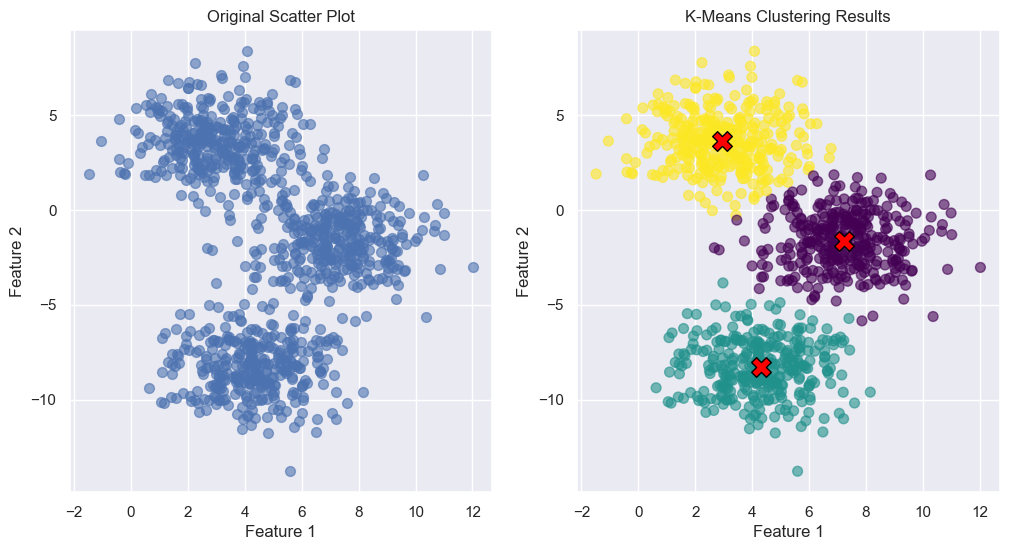

2024-05-22 16:32:58,816 - INFO - Running KMeans with 1 clusters
2024-05-22 16:32:58,823 - INFO - Running KMeans with 2 clusters
2024-05-22 16:32:58,860 - INFO - Running KMeans with 3 clusters
2024-05-22 16:32:58,905 - INFO - Running KMeans with 4 clusters
2024-05-22 16:32:58,954 - INFO - Running KMeans with 5 clusters


Converged at iteration 1
Converged at iteration 7
Converged at iteration 6
Converged at iteration 5


2024-05-22 16:32:59,334 - INFO - Running KMeans with 6 clusters


Converged at iteration 38


2024-05-22 16:32:59,569 - INFO - Running KMeans with 7 clusters


Converged at iteration 19


2024-05-22 16:33:00,166 - INFO - Running KMeans with 8 clusters


Converged at iteration 44


2024-05-22 16:33:00,419 - INFO - Running KMeans with 9 clusters


Converged at iteration 16


2024-05-22 16:33:00,638 - INFO - Running KMeans with 10 clusters


Converged at iteration 12
Converged at iteration 59


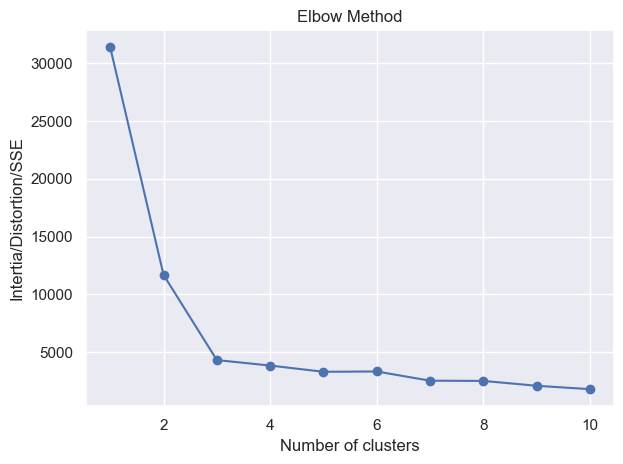

In [3]:
plot_kmeans_clusters_and_elbow(K=3, init="random", max_iter=500, random_state=1992)

Another example.

In [4]:
X = np.array(
    [
        [1, 2],
        [1, 4],
        [1, 0],
        [10, 2],
        [10, 4],
        [10, 0],
    ]
)
kmeans = KMeansLloyd(num_clusters=2, init="random", max_iter=500, random_state=1992)
kmeans.fit(X)

y_preds = kmeans.predict([[0, 0], [12, 3]])

sk_kmeans = KMeans(n_clusters=2, random_state=1992, n_init="auto", algorithm="lloyd", max_iter=500)
sk_kmeans.fit(X)

y_preds = kmeans.predict([[0, 0], [12, 3]])
sk_y_preds = sk_kmeans.predict([[0, 0], [12, 3]])

df = display_results(kmeans, sk_kmeans, X, y_preds, sk_y_preds)

Converged at iteration 1


In [5]:
df

,Attribute,Mine,Sklearn
0,Number of Clusters,2,2
1,Centroids,"[[5.5, 4.0], [5.5, 1.0]]","[[10.0, 2.0], [1.0, 2.0]]"
2,Labels,"[1, 0, 1, 1, 0, 1]","[1, 1, 1, 0, 0, 0]"
3,Inertia,125.5,16.0
4,Clusters,"{0: [[1, 4], [10, 4]], 1: [[1, 2], [1, 0], [10...","{0: [[10, 2], [10, 4], [10, 0]], 1: [[1, 2], [..."
5,Predicted Labels for New Data,"[1, 0]","[1, 0]"


## Evaluation (Performance Metrics) 

### Contigency Matrix and Purity Score

Now we code up purity score with helper functions `contingency_matrix` and `purity_score`. What are they?

Let's consider a dataset with $N$ samples and $K$ classes. The contingency matrix $C$ is an $K \times K$ matrix that represents the number of samples in the true class labels and the predicted class labels. For example, if the true class label of sample $i$ is $j$ and the predicted class label of sample $i$ is $k$, then $C_{j,k}$ is incremented by 1.

The contingency matrix $C$ can be used to calculate the Rand index, also known as the purity score, which measures the similarity between the true class labels and the predicted class labels. The Rand index is defined as the ratio of the number of pairs of samples that are either both in the same cluster or in different clusters in the predicted result and in the true class labels, to the total number of pairs of samples. Mathematically, the Rand index can be defined as:

$$R = \frac{(a + d)}{(a + b + c + d)}$$

where:

- $a$ is the number of pairs of samples that are in the same cluster in both the predicted result and the true class labels.
- $b$ is the number of pairs of samples that are in the same cluster in the predicted result and in different clusters in the true class labels.
- $c$ is the number of pairs of samples that are in different clusters in the predicted result and in the same cluster in the true class labels.
- $d$ is the number of pairs of samples that are in different clusters in both the predicted result and the true class labels.

The Rand index ranges from 0, indicating a poor match between the true class labels and the predicted class labels, to 1, indicating a perfect match. The Rand index is a widely used evaluation metric for clustering algorithms, and is often used to compare the performance of different clustering algorithms on a given dataset.

In [6]:
from typing import Union
import pandas as pd

def contingency_matrix(
    y_trues: np.ndarray, y_preds: np.ndarray, as_dataframe: bool = False
) -> Union[pd.DataFrame, np.ndarray]:
    # fmt: off
    classes, class_idx = np.unique(y_trues, return_inverse=True)     # get the unique classes and their indices
    clusters, cluster_idx = np.unique(y_preds, return_inverse=True)  # get the unique clusters and their indices
    num_classes, num_clusters = classes.shape[0], clusters.shape[0] # get the number of classes and clusters
    # fmt: on

    # initialize the contingency matrix with shape num_classes x num_clusters
    # exactly the same as the confusion matrix but in confusion matrix
    # the rows are the true labels and the columns are the predicted labels
    # and hence is num_classes x num_classes instead of num_classes x num_clusters
    # however in kmeans for example it is possible to have len(np.unique(y_true)) != len(np.unique(y_pred)
    # i.e. the number of clusters is not equal to the number of classes
    contingency_matrix = np.zeros((num_classes, num_clusters), dtype=np.int64)

    # note however y_true and y_pred are same sequence of samples
    for i in range(class_idx.shape[0]):
        # loop through each sample and increment the contingency matrix
        # at the row corresponding to the true label and column corresponding to the predicted label
        # so if the sample index is i = 0, and class_idx[i] = 1 and cluster_idx[i] = 2
        # this means the gt label is 1 and the predicted label is 2
        # so we increment the contingency matrix at row 1 and column 2 by 1
        # then for each row, which is the row for each gt label,
        # we see which cluster has the highest number of samples and that is the cluster
        # that the gt label is most likely to belong to.
        # in other words since kmeans permutes the labels, we can't just compare the labels
        # directly.
        contingency_matrix[class_idx[i], cluster_idx[i]] += 1

    # row is the true label and column is the predicted label
    if as_dataframe:
        return pd.DataFrame(
            contingency_matrix,
            index=[f"true={c}" for c in classes],
            columns=[f"pred={c}" for c in clusters],
        )
    return contingency_matrix


def purity_score(
    y_trues: np.ndarray, y_preds: np.ndarray, per_cluster: bool = False
) -> float:
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix_ = contingency_matrix(y_trues, y_preds, as_dataframe=False)

    # total purity is the max value in each column divided by the sum of the matrix
    # this means for each cluster k, we find the gt label that has the most samples in that cluster
    # and then sum up all clusters and we divide by the total number of samples in all clusters

    # if per_cluster is True, we return the purity for each cluster
    # this means instead of sum up all clusters, we return the purity for each cluster.
    if per_cluster:
        return np.amax(contingency_matrix_, axis=0) / np.sum(
            contingency_matrix_, axis=0
        )
    # return purity which is the sum of the max values in each column divided by the sum of the matrix
    return np.sum(np.amax(contingency_matrix_, axis=0)) / np.sum(contingency_matrix_)


In [7]:
def display_contingency_and_purity(
    y_trues: np.ndarray,
    y_preds: np.ndarray,
    as_dataframe: bool = True,
    per_cluster: bool = False,
) -> None:
    """Display contingency matrix and purity score for clustering."""
    # compute contingency matrix
    contingency_matrix_ = contingency_matrix(
        y_trues, y_preds, as_dataframe=as_dataframe
    )
    display(contingency_matrix_)

    purity = purity_score(y_trues, y_preds, per_cluster=per_cluster)
    print(f"Purity score: {purity:.4f}")

## K-Means Algorithm on IRIS

We use first two features of IRIS dataset to visualize the clusters.

In [8]:
X, y = load_iris(return_X_y=True)
X = X[:, :2] # only use the first two features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [9]:
kmeans = KMeansLloyd(num_clusters=3, init="random", max_iter=500, random_state=2023)
kmeans.fit(X_train)

Converged at iteration 13


KMeansLloyd()

In [10]:
print(f"There are {kmeans.num_clusters} clusters.")
print(f"The centroids are\n{kmeans.centroids}.")
print(f"The labels predicted are {kmeans.labels}.")
print(f"The inertia is {kmeans.inertia}.")

There are 3 clusters.
The centroids are
[[5.04615385 3.48205128]
 [5.62352941 2.68529412]
 [6.65957447 3.02978723]].
The labels predicted are [2 1 0 2 1 1 1 2 0 1 1 0 2 2 2 1 0 1 2 0 1 2 1 2 1 2 1 0 0 1 0 2 1 0 0 0 0
 2 1 0 1 1 0 2 0 2 1 1 2 1 2 0 1 2 2 2 2 2 0 2 0 2 0 2 1 1 0 0 2 2 0 2 0 2
 2 1 0 2 2 0 1 0 0 1 2 1 0 0 2 2 0 2 1 2 0 0 0 1 0 0 2 2 2 1 2 2 2 0 1 1 0
 2 1 0 1 0 2 2 2 2].
The inertia is 28.92967186547287.


In [11]:
y_preds = kmeans.predict(X_test)
display_contingency_and_purity(y_test, y_preds, per_cluster=False)

,pred=0,pred=1,pred=2
true=0,10,0,0
true=1,0,8,0
true=2,0,3,9


Purity score: 0.9000


Let's visualize where the centroids are.

In [12]:
def plot_scatter(
    ax: plt.Axes, x: np.ndarray, y: np.ndarray, **kwargs: Any
) -> PathCollection:
    """Plot scatter plot."""
    return ax.scatter(x, y, **kwargs)

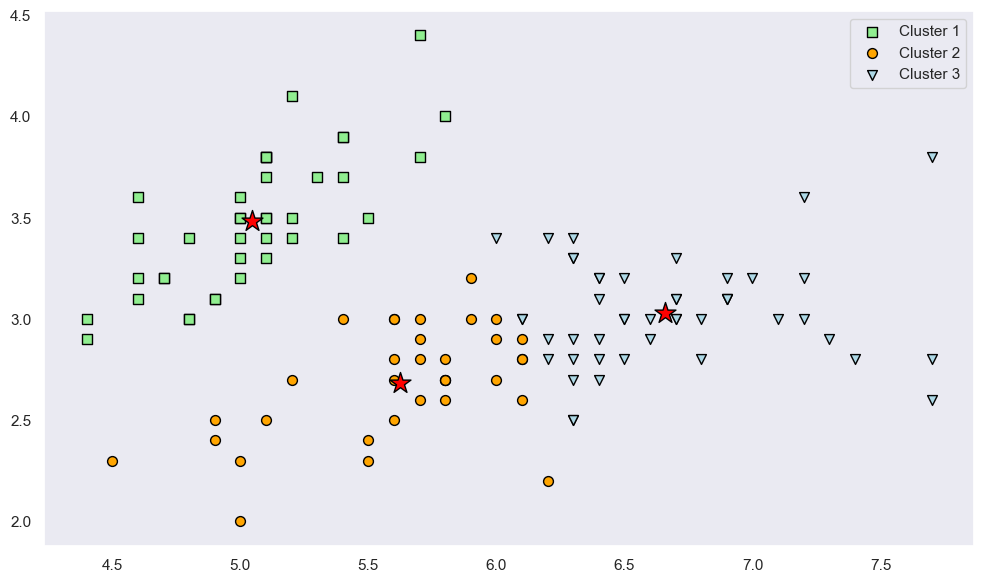

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

labels = kmeans.labels

# Note: X_train[y_train == 0] is NOT the same as X_train[labels == 0]
cluster_1 = X_train[labels == 0]  # cluster 1
cluster_2 = X_train[labels == 1]  # cluster 2
cluster_3 = X_train[labels == 2]  # cluster 3

scatter_1 = plot_scatter(
    ax,
    cluster_1[:, 0],
    cluster_1[:, 1],
    s=50,
    c="lightgreen",
    marker="s",
    edgecolor="black",
    label="Cluster 1",
)
scatter_2 = plot_scatter(
    ax,
    cluster_2[:, 0],
    cluster_2[:, 1],
    s=50,
    c="orange",
    marker="o",
    edgecolor="black",
    label="Cluster 2",
)
scatter_3 = plot_scatter(
    ax,
    cluster_3[:, 0],
    cluster_3[:, 1],
    s=50,
    c="lightblue",
    marker="v",
    edgecolor="black",
    label="Cluster 3",
)

centroids = kmeans.centroids

plot_scatter(
    ax,
    centroids[:, 0],
    centroids[:, 1],
    s=250,
    marker="*",
    c="red",
    edgecolor="black",
    label="Centroids",
)

plt.legend(handles=[scatter_1, scatter_2, scatter_3])
plt.grid(False)
plt.tight_layout()
plt.show()

In [14]:
sk_kmeans = KMeans(
    n_clusters=3,
    random_state=2023,
    n_init=1,
    algorithm="lloyd",
    max_iter=1000,
    init="random",
)
sk_kmeans.fit(X_train)

KMeans(init='random', max_iter=1000, n_clusters=3, n_init=1, random_state=2023)

In [16]:
print(f"The labels predicted are {sk_kmeans.labels_}.")
print(f"The inertia is {sk_kmeans.inertia_}.")
np.testing.assert_allclose(kmeans.inertia, sk_kmeans.inertia_, rtol=1e-1)

The labels predicted are [1 0 2 1 0 0 2 1 2 0 0 2 1 1 1 0 2 0 1 2 0 1 0 1 0 1 0 2 2 0 2 0 0 2 2 2 2
 0 0 2 0 0 2 1 2 1 0 0 1 0 0 2 0 1 1 1 1 1 2 1 2 1 2 0 0 0 2 2 1 0 2 1 2 1
 0 0 2 0 1 2 0 2 2 0 1 0 2 2 1 1 2 0 0 1 2 2 2 0 2 2 1 1 0 0 1 1 1 2 0 0 2
 1 0 2 0 2 1 1 1 1].
The inertia is 28.630194235588974.


In [17]:
y_preds = sk_kmeans.predict(X_test)
display_contingency_and_purity(y_test, y_preds, per_cluster=False)

,pred=0,pred=1,pred=2
true=0,0,0,10
true=1,8,0,0
true=2,3,9,0


Purity score: 0.9000


Let's try use elbow method. We fix the same seed but change the number of clusters in
each run. For example, if I want to test 2, 3, 4, 5, 6, 7, 8, 9, 10 clusters, I will
define `max_clusters = 10` and the code will loop through 2 to 10 clusters.

Note that the code will auto start from 2 clusters and end at `max_clusters` clusters
as it does not make sense to have 1 cluster.

2024-05-22 16:33:43,887 - INFO - Running KMeans with 1 clusters
2024-05-22 16:33:43,891 - INFO - Running KMeans with 2 clusters
2024-05-22 16:33:43,898 - INFO - Running KMeans with 3 clusters
2024-05-22 16:33:43,914 - INFO - Running KMeans with 4 clusters
2024-05-22 16:33:43,932 - INFO - Running KMeans with 5 clusters
/opt/homebrew/Caskroom/miniconda/base/envs/omniverse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniconda/base/envs/omniverse/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Converged at iteration 1
Converged at iteration 4
Converged at iteration 10
Converged at iteration 3


2024-05-22 16:33:44,574 - INFO - Running KMeans with 6 clusters
2024-05-22 16:33:45,304 - INFO - Running KMeans with 7 clusters
2024-05-22 16:33:46,161 - INFO - Running KMeans with 8 clusters
2024-05-22 16:33:46,178 - INFO - Running KMeans with 9 clusters


Converged at iteration 6


2024-05-22 16:33:47,235 - INFO - Running KMeans with 10 clusters


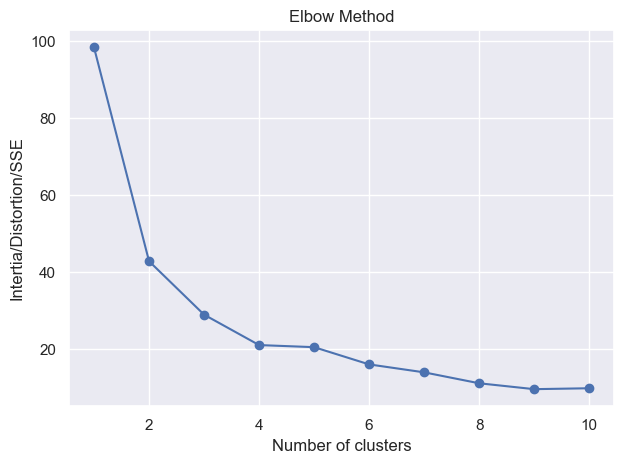

In [18]:
_ = elbow_method(X_train, min_clusters=1, max_clusters=10)

What happened here?

```bash
/usr/local/Caskroom/miniforge/base/envs/gaohn/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/Caskroom/miniforge/base/envs/gaohn/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
```

This means 

```python
mu_k = np.mean(cluster, axis=0)  # compute the mean of the cluster
```

is returning `nan` because the cluster is empty. This is because for that cluster in
the previous iteration, there is no data point assigned to it. This can happen because
no data points are close enough to the centroid of that cluster. In this case, this
is likely a case of [bad initialization](https://datascience.stackexchange.com/questions/44897/k-means-clustering-what-to-do-if-a-cluster-has-0-elements), and to solve this, either you
reduce the number of clusters or you re-run the algorithm with different seed. Of course,
if you initialize data points to be far apart (e.g. K-Means++), this will be less likely
to happen.

Sometimes people also just decrement the number of clusters by 1 and continue the
program but it really must depend on the use case.

We decrease the `max_clusters` to 6 and re-run the code. 

2024-05-22 16:34:13,887 - INFO - Running KMeans with 1 clusters
2024-05-22 16:34:13,891 - INFO - Running KMeans with 2 clusters
2024-05-22 16:34:13,897 - INFO - Running KMeans with 3 clusters
2024-05-22 16:34:13,905 - INFO - Running KMeans with 4 clusters
2024-05-22 16:34:13,924 - INFO - Running KMeans with 5 clusters
2024-05-22 16:34:13,937 - INFO - Running KMeans with 6 clusters


Converged at iteration 1
Converged at iteration 2
Converged at iteration 4
Converged at iteration 8
Converged at iteration 6
Converged at iteration 6


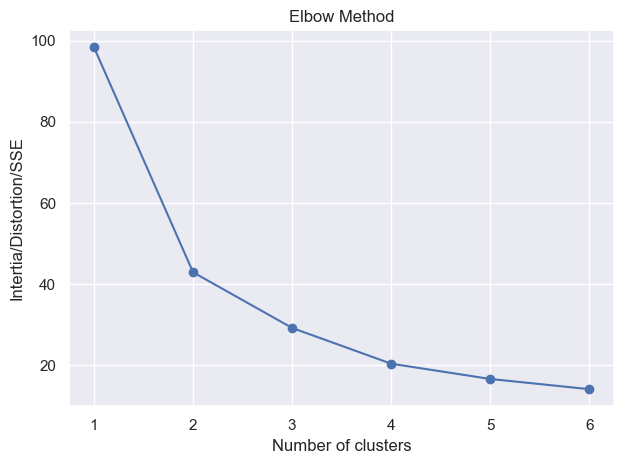

In [19]:
_ = elbow_method(X_train, min_clusters=1, max_clusters=6)

In [20]:
def perform_kmeans_on_iris() -> Tuple[Any, Any]:
    """
    Perform k-means clustering on the Iris dataset using both custom KMeansLloyd
    and scikit-learn's KMeans.

    Parameters
    ----------
    num_clusters : int
        Number of clusters for k-means.
    init : str
        Initialization method for centroids.
    max_iter : int
        Maximum number of iterations.
    random_state : int
        Random seed for reproducibility.

    Returns
    -------
    tuple
        Tuple containing results from custom KMeansLloyd and scikit-learn's KMeans.
    """

    X, y = load_iris(return_X_y=True)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    kmeans = KMeansLloyd(num_clusters=3, init="random", max_iter=500, random_state=2023)
    kmeans.fit(X_train)
    pprint(kmeans.labels)
    pprint(kmeans.inertia)

    y_preds = kmeans.predict(X_train)
    assert np.all(y_preds == kmeans.labels)
    contingency_matrix_ = contingency_matrix(y_train, y_preds)
    pprint(contingency_matrix_)
    # TODO: try K = 4

    purity = purity_score(y_train, y_preds)
    pprint(purity)
    purity_per_cluster = purity_score(y_train, y_preds, per_cluster=True)
    print("Purity per cluster: -------------------")
    pprint(purity_per_cluster)

    sk_kmeans = KMeans(
        n_clusters=3,
        random_state=2023,
        n_init=1,
        algorithm="lloyd",
        max_iter=500,
        init="random",
    )
    sk_kmeans.fit(X_train)
    pprint(sk_kmeans.labels_)
    pprint(sk_kmeans.inertia_)

    y_preds = sk_kmeans.predict(X_train)
    assert np.all(y_preds == sk_kmeans.labels_)
    contingency_matrix_ = contingency_matrix(y_train, y_preds)
    pprint(contingency_matrix_)

    purity = purity_score(y_train, y_preds)
    print("Purity Score: -------------------")
    pprint(purity)

perform_kmeans_on_iris()

Converged at iteration 3


array([0, 1, 1, 0, 2, 0, 0, 0, 1, 2, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 0, 1,
│      1, 2, 1, 0, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 1, 0, 2, 1, 2, 2, 1, 1,
│      1, 2, 1, 0, 0, 1, 0, 2, 1, 0, 0, 1, 0, 0, 2, 0, 2, 0, 1, 2, 1, 0,
│      0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 2, 0, 1, 2, 1, 0, 0, 2, 2,
│      1, 2, 1, 1, 2, 0, 0, 0, 1, 2, 2, 0, 2, 0, 1, 0, 1, 0, 1, 0, 0, 1,
│      0, 1, 0, 0, 0, 0, 2, 0, 0, 1])

66.76046437346437

array([[ 0, 37,  0],
│      [44,  0,  3],
│      [11,  0, 25]])

0.8833333333333333

Purity per cluster: -------------------


array([0.8       , 1.        , 0.89285714])

array([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 1,
│      2, 0, 1, 0, 0, 0, 0, 0, 2, 1, 2, 0, 1, 0, 2, 0, 0, 2, 0, 0, 2, 1,
│      2, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0,
│      0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0,
│      2, 0, 2, 2, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 2, 0, 2, 0, 0, 1,
│      0, 1, 0, 0, 0, 0, 0, 0, 0, 2], dtype=int32)

110.9471012658228

array([[ 0, 17, 20],
│      [43,  4,  0],
│      [36,  0,  0]])

Purity Score: -------------------


0.6666666666666666

## K-Means Algorithm on MNIST

In [ ]:
# X, y = load_digits(return_X_y=True)
# (num_samples, num_features), num_classes = X.shape, np.unique(y).size
# print(f"There are {num_samples} samples and {num_features} features.")
# print(f"Shape of X is {X.shape} and shape of y is {y.shape}.")

In [21]:
import tensorflow as tf

In [22]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [23]:
num_classes = np.unique(y_train).size

X_train = X_train.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)

# Do not run this multiple times in jupyter notebook
X_train = X_train / 255.0
X_test = X_test / 255.0

print(f"Shape of X_train is {X_train.shape} and shape of X_test is {X_test.shape}.")

Shape of X_train is (60000, 784) and shape of X_test is (10000, 784).


ATTENTION: due to the implementation, vectorization is not fully
optimized and hence we train on `X_test` instead of `X_train` to
quickly get some results.

In [24]:
kmeans = KMeansLloyd(
    num_clusters=num_classes, init="random", max_iter=20, random_state=42
)

kmeans.fit(X_test)

KMeansLloyd()

In [25]:
print(f"The inertia is {kmeans.inertia}.")

The inertia is 390332.9696603103.


In [26]:
sk_kmeans = KMeans(
    n_clusters=num_classes,
    random_state=42,
    n_init=1,
    init="random",
    max_iter=500,
    algorithm="lloyd",
)

sk_kmeans.fit(X_test)

KMeans(init='random', max_iter=500, n_clusters=10, n_init=1, random_state=42)

The inertia looks frighteningly high because of the large number of samples.
Since our cost function is SSE, it sums all errors over all samples. Average SSE
will tells us roughly the loss per sample.

In [27]:
print(f"The inertia is {sk_kmeans.inertia_}.")

The inertia is 389420.4071274942.


In [28]:
y_preds = kmeans.labels
contingency_matrix_ = contingency_matrix(y_test, y_preds, as_dataframe=True)
contingency_matrix_

,pred=0,pred=1,pred=2,pred=3,pred=4,pred=5,pred=6,pred=7,pred=8,pred=9
true=0,778,117,7,1,1,2,22,51,1,0
true=1,0,1,0,0,0,0,2,4,484,644
true=2,17,25,42,7,13,707,17,45,119,40
true=3,4,78,7,22,12,60,2,781,2,42
true=4,1,56,353,299,223,1,13,0,19,17
true=5,5,376,27,44,15,3,11,372,22,17
true=6,18,178,70,3,1,4,663,2,4,15
true=7,1,1,92,313,527,14,0,1,47,32
true=8,9,314,15,65,58,30,5,418,40,20
true=9,10,13,202,473,275,2,1,11,7,15


In [29]:
purity = purity_score(y_test, y_preds)
print(purity)
purity_per_cluster = purity_score(y_test, y_preds, per_cluster=True)
print(purity_per_cluster)

0.5786
[0.92289442 0.3244176  0.43312883 0.38549307 0.46844444 0.85905225
 0.90081522 0.46350148 0.64966443 0.76484561]


In [30]:
sk_y_preds = sk_kmeans.labels_
sk_contingency_matrix_ = contingency_matrix(y_test, sk_y_preds, as_dataframe=True)
sk_contingency_matrix_

,pred=0,pred=1,pred=2,pred=3,pred=4,pred=5,pred=6,pred=7,pred=8,pred=9
true=0,0,1,1,3,28,51,9,35,820,32
true=1,644,0,485,0,2,3,0,1,0,0
true=2,47,9,123,26,23,50,692,28,16,18
true=3,63,6,4,14,5,706,48,148,2,14
true=4,26,210,9,441,20,0,2,0,1,273
true=5,26,19,17,43,10,278,9,280,5,205
true=6,49,0,8,14,798,6,14,28,22,19
true=7,32,507,46,138,0,0,10,1,2,292
true=8,29,23,33,25,7,140,11,603,8,95
true=9,19,424,3,362,2,7,2,15,8,167


In [31]:
purity = purity_score(y_test, sk_y_preds)
print(purity)
purity_per_cluster = purity_score(y_test, sk_y_preds, per_cluster=True)
print(purity_per_cluster)

0.5988
[0.68877005 0.42285238 0.66529492 0.41369606 0.89162011 0.56889605
 0.86825596 0.52941176 0.92760181 0.26188341]


Use distance metric `manhattan` instead of `euclidean` to see if we can get better results.

In [32]:
kmeans = KMeansLloyd(
    num_clusters=num_classes, init="random", max_iter=150, random_state=2023, metric="manhattan"
)

kmeans.fit(X_test)

Converged at iteration 49


KMeansLloyd()

In [33]:
print(f"The inertia is {kmeans.inertia}.")

The inertia is 920098.4973441634.


In [34]:
y_preds = kmeans.labels
contingency_matrix_ = contingency_matrix(y_test, y_preds, as_dataframe=True)
contingency_matrix_

,pred=0,pred=1,pred=2,pred=3,pred=4,pred=5,pred=6,pred=7,pred=8,pred=9
true=0,0,410,7,4,374,129,20,13,8,15
true=1,0,0,0,0,0,1,1134,0,0,0
true=2,488,16,25,11,2,20,431,15,3,21
true=3,6,0,246,15,2,13,304,403,0,21
true=4,0,0,0,494,0,21,97,0,19,351
true=5,0,3,161,68,8,39,275,215,1,122
true=6,0,4,0,4,5,525,111,1,308,0
true=7,5,0,0,264,0,0,151,0,0,608
true=8,0,1,212,43,7,10,435,105,0,161
true=9,1,6,10,499,0,2,66,6,7,412


In [35]:
purity = purity_score(y_test, y_preds)
print(purity)
purity_per_cluster = purity_score(y_test, y_preds, per_cluster=True)
print(purity_per_cluster)

0.4995
[0.976      0.93181818 0.37216339 0.35592011 0.93969849 0.69078947
 0.375      0.53166227 0.89017341 0.35534775]


A version with `sklearn`'s `load_digits` dataset.

In [36]:
def perform_kmeans_on_mnist() -> None:
    X, y = load_digits(return_X_y=True)
    (n_samples, n_features), n_digits = X.shape, np.unique(y).size

    pprint(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train = X_train / 255.0
    X_test = X_test / 255.0

    kmeans = KMeansLloyd(num_clusters=n_digits, init="random", max_iter=50000, random_state=42)
    kmeans.fit(X_train)
    pprint(kmeans.labels)
    pprint(kmeans.inertia)

    y_preds = kmeans.predict(X_test)
    contingency_matrix_ = contingency_matrix(y_test, y_preds, as_dataframe=True)
    pprint(contingency_matrix_)

    purity = purity_score(y_test, y_preds)
    pprint(purity)

    purity_per_cluster = purity_score(y_test, y_preds, per_cluster=True)
    pprint(purity_per_cluster)

    sk_kmeans = KMeans(
        n_clusters=n_digits,
        random_state=42,
        n_init=1,
        max_iter=500,
        init="random",
        algorithm="lloyd",
    )
    sk_kmeans.fit(X_train)
    # Note that the labels can be permuted.
    pprint(sk_kmeans.labels_)
    pprint(sk_kmeans.inertia_)

perform_kmeans_on_mnist()


'# digits: 10; # samples: 1797; # features 64'

Converged at iteration 18


array([3, 1, 6, ..., 2, 8, 7])

14.30291978655031

│   │   pred=0  pred=1  pred=2  pred=3  pred=4  pred=5  pred=6  pred=7  \
true=0       0       0       0       0       0       0       0      34   
true=1      19       0      11       0       0       0       0       0   
true=2       1       0      23       1       0       0       0       0   
true=3       1       0       0      13       3       1       0       0   
true=4       1      36       0       0       2       0       0       0   
true=5       0       0       0      11       0      38       0       0   
true=6       0       0       0       0       0       0      36       0   
true=7       2       0       0       0      31       0       0       0   
true=8      12       0       1       0       0       2       0       0   
true=9       0       0       0      24       1       1       0       0   
│   │   
│   │   pred=8  pred=9  
true=0       0       0  
true=1       0      13  
true=2       1       0  
true=3      23       0  
true=4       0       1  
true=5       0       0  
true=6       0       0  
true=7       0       2  
true=8       9       2  
true=9       3       1

0.7694444444444445

array([0.52777778, 1.        , 0.65714286, 0.48979592, 0.83783784,
│      0.9047619 , 1.        , 1.        , 0.63888889, 0.68421053])

array([2, 5, 1, ..., 7, 2, 8], dtype=int32)

14.811883582334536

## References and Further Readings

- [Goodboychan: K-Means Clustering for Imagery Analysis](https://goodboychan.github.io/python/machine_learning/natural_language_processing/vision/2020/10/26/01-K-Means-Clustering-for-Imagery-Analysis.html)
- [Nathaniel Dake: K-Means Clustering](https://www.nathanieldake.com/Machine_Learning/04-Unsupervised_Learning_Cluster_Analysis-02-Cluster-Analysis-K-Means-Clustering.html)
- [Scikit-Learn: K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)